# Ejercicio 1

### Introduccion

El dataset que subimos consiste en un diccionario que consta de tres elementos:

`tiempos_disparos` es una lista de 1000 elementos. Cada elemento corresponde a los tiempos de disparo de una neurona (unidades en $s$).

`velocidades` es un vector con valores de velocidad en el tiempo (unidades en $m/s$).

`tiempos_velocidades` es un vector de tiempos correspondiente a cada valor de velocidad (unidades en $s$).

El dataset fue simulado generando un vector de velocidad de forma aleatoria (de tipo *random walk* gaussiano) y trenes de disparos independientes provenientes de un proceso de Poisson no estacionario (para quienes le interese, ya lo vamos a ver pero [aca](https://elephant.readthedocs.io/en/latest/index.html) pueden aprender de una libreria muy piola para hacerlo). Esto ultimo quiere decir que generamos disparos de neuronas independientes mediante distribuciones de Poisson cuyas medias de disparo $\lambda$ variaban en el tiempo en funcion de la velocidad $v$ siguiendo un modelo mas o menos como este



$$\lambda_i(v) = r_i + \alpha_i\left[v-v_{i}^{th}\right]^+ $$

donde la operacion $[\alpha]^+=\alpha$ si $\alpha>0$ y $[\alpha]^+=0$ si $\alpha<0$. Lo importante es que es un modelo de respuesta lineal a la velocidad, algo relativamente verosimil a lo que se ve en varios tipos de neuronas que codifican velocidad en distintas partes del cerebro (aunque bastante muy de juguete).

La idea de este ejercicio es que sea bastante guiado para que tengan un primer appoach algo metodico para ver y aplicar PCA, pero la posta va a estar en el ejercicio 2.

### Importamos librerias utiles (pueden usar las que quieran)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

#### Primero, descarguen la data y carguenla en el notebook.

In [2]:
import pickle
mypath = '' #aca pongan la direccion del archivo

with open(mypath+'DataTP1.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [3]:
tiempos_disparos = data['tiempos_disparos']
tiempos_velocidades = data['tiempos_velocidades']
velocidades = data['velocidades']
len(tiempos_disparos)

1000

## Inciso (a)

- Realizar un rasterplot de los trenes de disparo en el tiempo
- Visualizar velocidad vs. tiempo

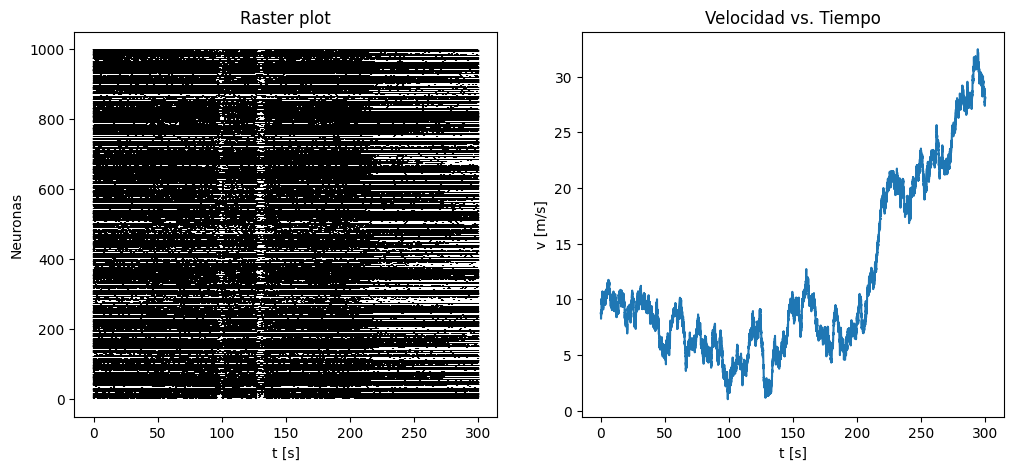

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].eventplot(tiempos_disparos, 'horizontal', color='k')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('Neuronas')
axs[0].set_title('Raster plot')
axs[1].plot(tiempos_velocidades, velocidades)
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('v [m/s]')
axs[1].set_title('Velocidad vs. Tiempo')
plt.show()

## Inciso (b)

Pasar los disparos a tasas de disparo realizando un promedio móvil con una ventana temporal adecuada



In [5]:
N = len(tiempos_disparos)
dt = np.mean(np.diff(tiempos_velocidades)) # [s]
time_window = 1e2*dt # [s]
skip = int(time_window/dt)
binned_tiempos_velocidades = tiempos_velocidades[::skip]
bin_velocidades = [np.mean(velocidades[i*int(time_window/dt):(i+1)*skip]) 
                   for i in range(len(binned_tiempos_velocidades)-1)]

tasa_disparo = np.zeros((N, len(binned_tiempos_velocidades)-1))
for n in range(tasa_disparo.shape[0]):
  tasa_disparo[n,:], _ = np.histogram(tiempos_disparos[n], bins=binned_tiempos_velocidades)

print(tasa_disparo.shape)
tasa_disparo

(1000, 300)


array([[ 7.,  5., 14., ..., 37., 31., 42.],
       [ 1.,  0.,  0., ...,  5.,  7.,  3.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [10., 14., 20., ..., 47., 42., 60.],
       [ 8.,  5.,  6., ..., 29., 25., 12.],
       [13., 12.,  8., ...,  5.,  6.,  4.]])

### Inciso (c)

Usando los datos del punto (b), visualizar la respuesta de las neuronas a las distintas velocidades ¿Todas responden de la misma forma?

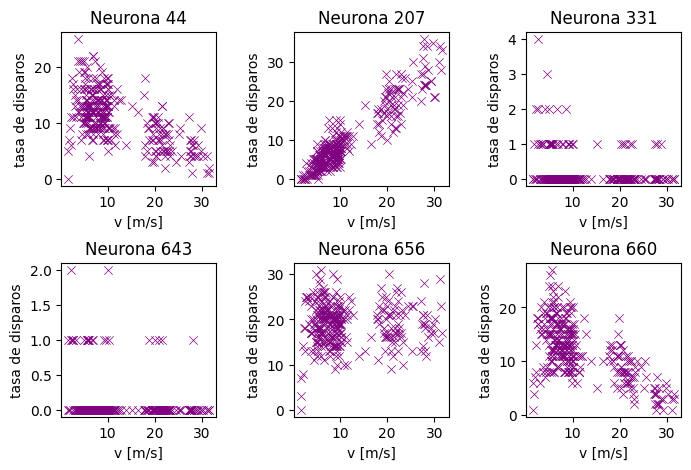

In [6]:
#Fijate en estas neuronas
indices_de_neuronas = [44, 207, 331, 643, 656, 660, 699, 779]

fig, axs = plt.subplots(2, 3, figsize=(8, 5))

for ax, idx in zip(axs.reshape(-1), indices_de_neuronas):
    ax.scatter(bin_velocidades, tasa_disparo[idx], c='purple', marker='x', linewidths=0.5)
    ax.set_title(f"Neurona {idx}")
    ax.set_xlabel('v [m/s]')
    ax.set_ylabel('tasa de disparos')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

La actividad de las neuronas es muy variada, con un amplio abanico de respuestas al mismo estímulo. Sin embargo, algunas neuronas parecen estar fuertemente correlacionadas con otras que responden en sintonía.

### Inciso (d)

Aplicar PCA sobre los datos del punto b y graficar la varianza explicada cumulativa ¿Cuántas dimensiones esperas que sean necesarias para capturar la dinámica relevante del problema?


In [7]:
# Realizar el analisis de PCA con sklearn
pca = PCA()
tasa_disparo_tras = tasa_disparo.T
pca.fit(tasa_disparo_tras)
pca_transformed_data = pca.transform(tasa_disparo_tras)

Varianza explicada por cada componente: 
0.801, 0.012, 0.004, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002 , ...


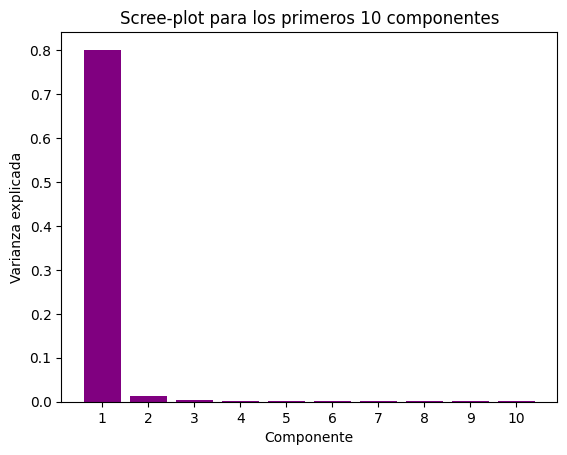

In [15]:
# Analizar la varianza aportada por los primeros componentes
cut_point = 10
main_components = np.arange(1, cut_point+1)
print('Varianza explicada por cada componente: ')
print(', '.join([f"{val:.3f}" for val in pca.explained_variance_ratio_[:cut_point]]), ', ...')

fig, ax = plt.subplots()
ax.bar(main_components, pca.explained_variance_ratio_[:cut_point], color='purple')
ax.set_ylabel('Varianza explicada')
ax.set_xlabel('Componente')
ax.set_xticks(main_components)
ax.set_title(rf"Scree-plot para los primeros {cut_point} componentes")
plt.show()

Como se aprecia en el scree-plot, el 80% de la varianza se explica por el primer componente principal, por lo que con tan solo los primeros 2 o 3 componentes podemos encapsular prácticamente todo el comportamiento neuronal conjunto.

### Inciso (e)

Visualizar en 2D
 - PC1 vs. PC2
 - PC1 vs. Velocidad
 - PC1 vs. tiempo

¿Tiene sentido en base a lo esperado?

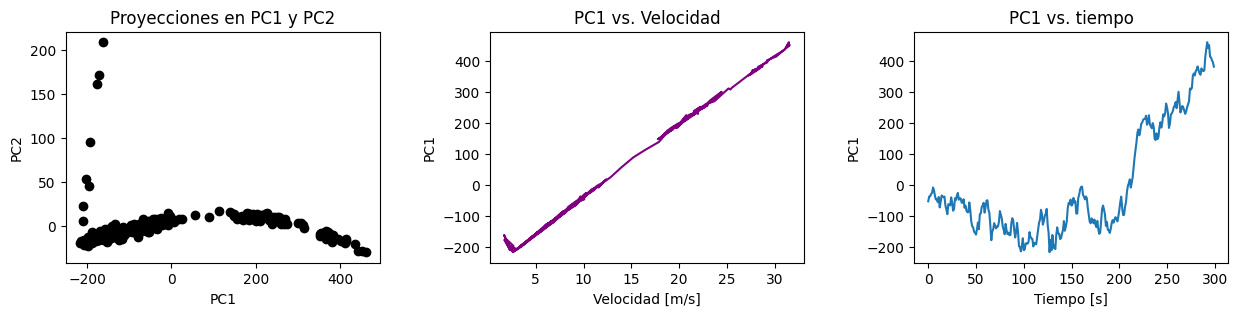

In [9]:
# Graficamos lo pedido
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs.reshape(-1)

axs[0].scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], c='black')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('Proyecciones en PC1 y PC2')

axs[1].plot(bin_velocidades,pca_transformed_data[:,0], color='Purple')
axs[1].set_xlabel('Velocidad [m/s]')
axs[1].set_ylabel('PC1')
axs[1].set_title('PC1 vs. Velocidad')

axs[2].plot(binned_tiempos_velocidades[:-1], pca_transformed_data[:,0])
axs[2].set_ylabel('PC1')
axs[2].set_xlabel('Tiempo [s]')
axs[2].set_title('PC1 vs. tiempo')

plt.subplots_adjust(wspace=0.35)
plt.show()

#### Conclusiones
- A niveles prácticos, el PC1 contiene prácticamente toda la varianza, a excepción de algunos outliers cuya varianza se explica en parte por el PC1
- Los otros 298 componentes no aportan prácticamente varianza en los datos
- Pareciera haber una relación casi perfectamente lineal entre el PC1 y la velocidad
- La gráfica de tiempo vs. PC1 es, en su morfología, muy similar a la de velocidad vs. tiempo. Esto se debe a la relación lineal entre ambas variables

Para visualizar con mayor detalle este efecto, graficaremos una versión escalada y desplazada del PCA1 junto a la velocidad en función del tiempo. Haremos una reconstrucción de la velocidad en función del PC1 mediante cuadrados mínimos.

In [16]:
# para hacer la regresión lineal, ignoramos la parte no lineal del gráfico anterior (para velocidades menores a 5 m/s)
bin_velocidades = np.array(bin_velocidades)
bin_vel_slice = bin_velocidades[bin_velocidades > 5]
PC1_slice = pca_transformed_data[:, 0][bin_velocidades > 5]

# aplicamos cuadrados minimos
A = np.ones((len(bin_vel_slice), 2))
A[:, 0] = bin_vel_slice
ls_parms = np.linalg.lstsq(A, PC1_slice)
m, c = tuple(ls_parms[0])
print(f"Pendiente: {m:.3f}, Ordenada al origen: {c:.3f}")

Pendiente: 23.190, Ordenada al origen: -272.317


C:\Users\gonza\AppData\Local\Temp\ipykernel_3220\3898836069.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ls_parms = np.linalg.lstsq(A, PC1_slice)


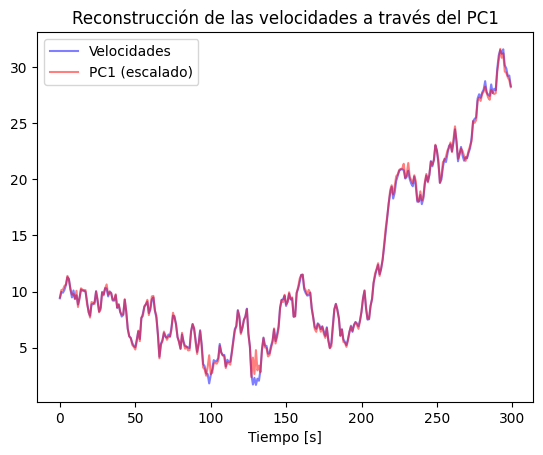

In [17]:
# escalamos y ploteamos
scaled_PC1 = (pca_transformed_data[:, 0] - c)/m

fig, ax = plt.subplots()
ax.plot(binned_tiempos_velocidades[:-1], bin_velocidades, color='blue', alpha=0.5, label='Velocidades')
ax.plot(binned_tiempos_velocidades[:-1], scaled_PC1, color='red', alpha=0.5, label='PC1 (escalado)')
ax.set_xlabel('Tiempo [s]')
ax.set_title('Reconstrucción de las velocidades a través del PC1')
plt.legend()
plt.show()